Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

Data Load

In [2]:
ev_res_df = pd.read_pickle('ev_res_df.pkl')
vt_res_df = pd.read_pickle('vt_res_df.pkl')

es_ret = ev_res_df['es_ret']
ev_pnl = ev_res_df['pnl']
ev_notional = ev_res_df['notional']
vt_pnl = vt_res_df['pnl']
vt_notional = vt_res_df['notional']

In [3]:
port_base_notional = ev_notional.max() + vt_notional.max()

pnl_df = pd.concat([ev_pnl, vt_pnl], axis=1, join='outer').fillna(0)
pnl_df.columns = ['EV', 'VT']

notional_df = pd.concat([ev_notional, vt_notional], axis=1, join='outer').fillna(0)
notional_df.columns = ['EV', 'VT']

port_base_ret = pnl_df.sum(axis=1) / port_base_notional
total_ret = pnl_df / port_base_notional

sr = port_base_ret.mean() * np.sqrt(252) / port_base_ret.std()
print(np.round(sr, 2))

0.97


Portfolio Performance

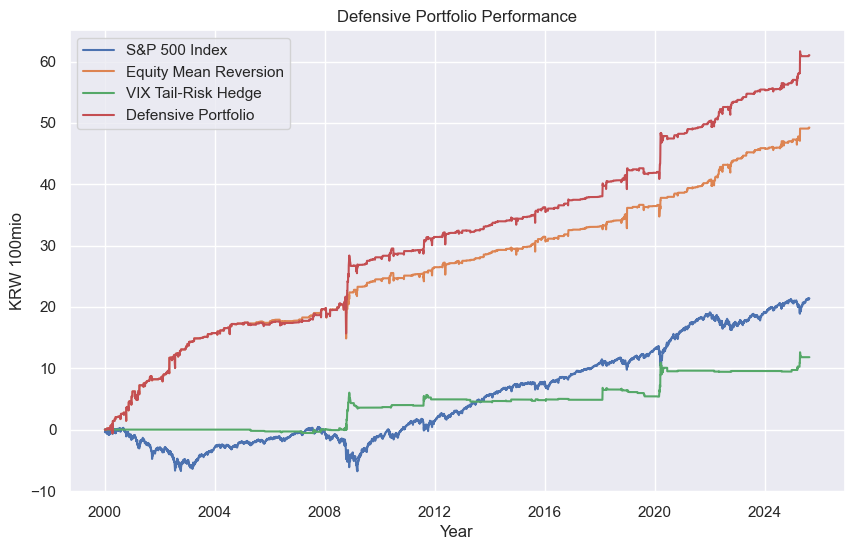

In [4]:
plt.figure(figsize=(10, 6))
plt.plot((es_ret*10).cumsum(), label='S&P 500 Index')
plt.plot((pnl_df/1e8).cumsum(), label=['Equity Mean Reversion', 'VIX Tail-Risk Hedge'])
plt.plot((pnl_df/1e8).sum(axis=1).cumsum(), label='Defensive Portfolio')
plt.title('Defensive Portfolio Performance')
plt.xlabel('Year')
plt.ylabel('KRW 100mio')
plt.legend()

Drawdown Plot

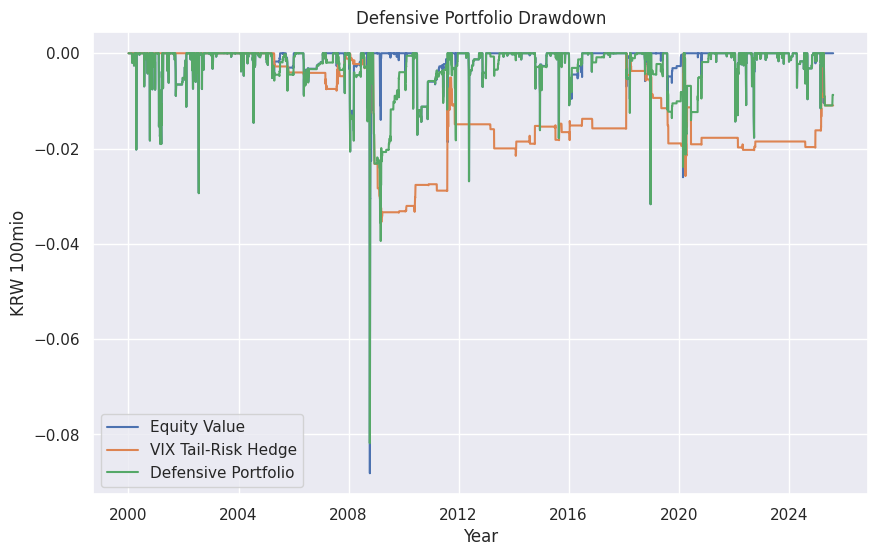

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(total_ret.cumsum() - total_ret.cumsum().cummax(), label=['Equity Value', 'VIX Tail-Risk Hedge'])
plt.plot(port_base_ret.cumsum() - port_base_ret.cumsum().cummax(), label='Defensive Portfolio')
plt.title('Defensive Portfolio Drawdown')
plt.xlabel('Year')
plt.ylabel('KRW 100mio')
plt.legend()

Quantile Analysis

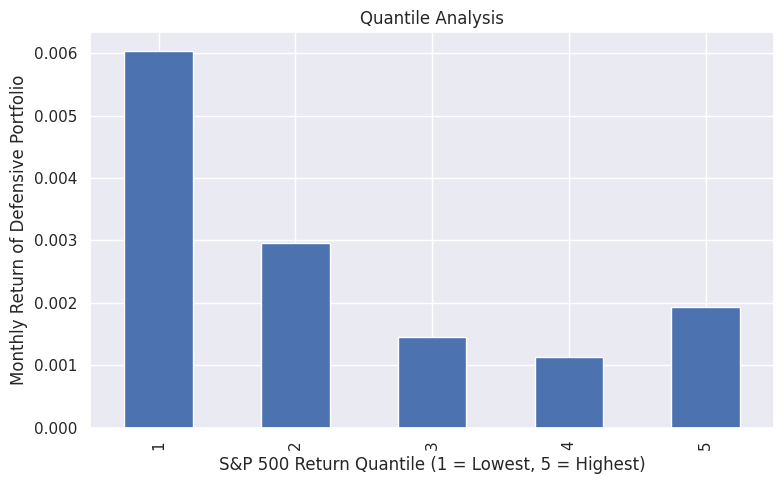

In [13]:
def_ret = total_ret[['EV', 'VT']].sum(axis=1)

strat_rets = pd.DataFrame({'SP500': es_ret.resample('M').sum(),
                           'Strategy': def_ret.resample('M').sum()}).dropna()

strat_rets['SP500_quantile'] = pd.qcut(strat_rets['SP500'], q=5, labels=False)

quantile_perf = strat_rets.groupby('SP500_quantile')['Strategy'].mean()

plt.figure(figsize=(8, 5))
quantile_perf.plot(kind='bar')
plt.xticks(ticks=range(len(quantile_perf)), labels=[str(i+1) for i in range(len(quantile_perf))])
plt.title("Quantile Analysis")
plt.xlabel("S&P 500 Return Quantile (1 = Lowest, 5 = Highest)")
plt.ylabel("Monthly Return of Defensive Portfolio")
plt.grid(True)
plt.tight_layout()
plt.show()


Monthly Performance

Text(0.5, 1.0, 'Monthly Performance')

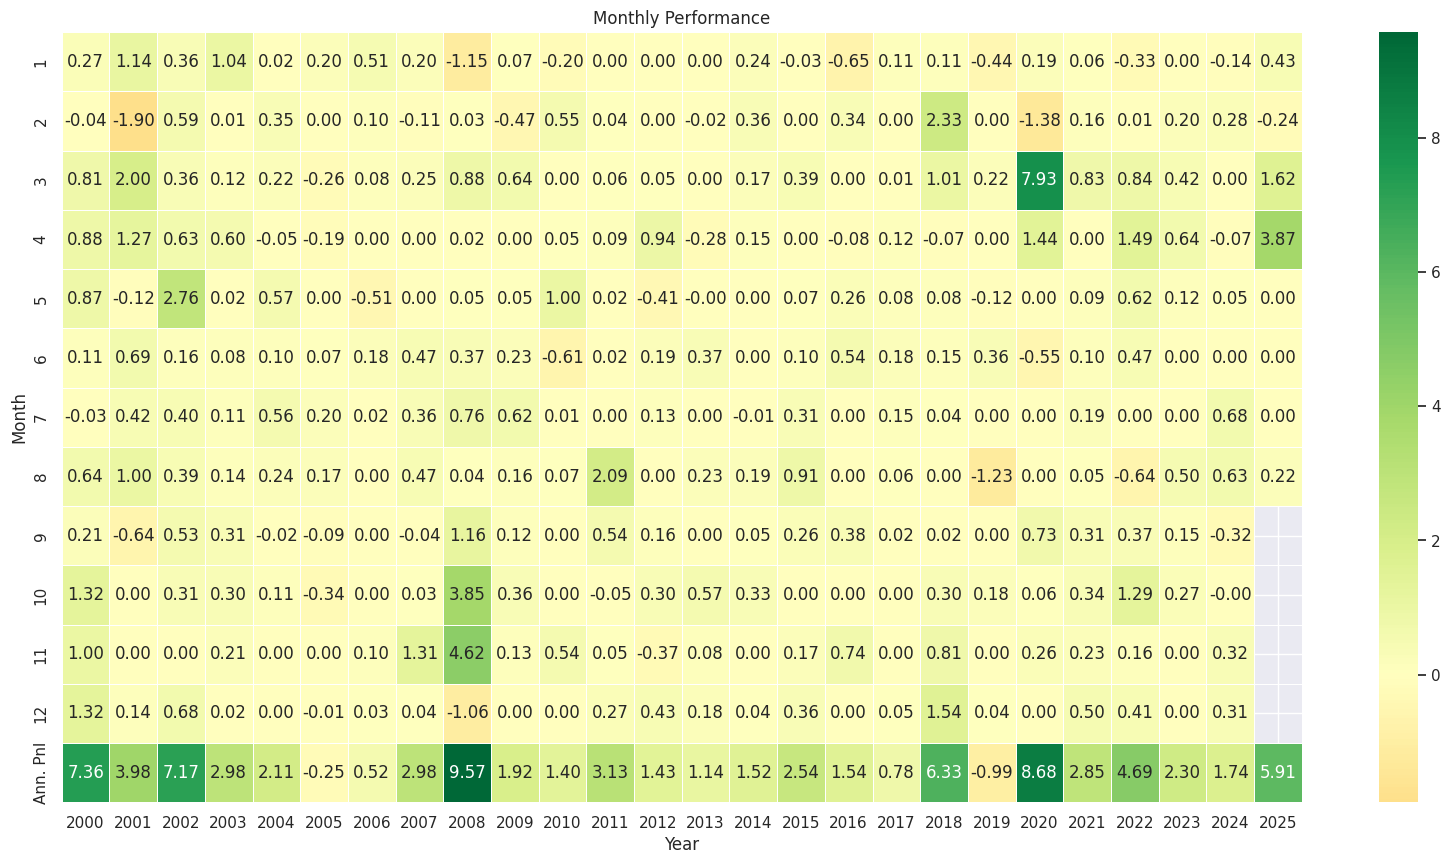

In [14]:
monthly_ret = def_ret.resample('M').sum().reset_index()
monthly_ret['Year'] = monthly_ret['index'].dt.year
monthly_ret['Month'] = monthly_ret['index'].dt.month
df_pivot = monthly_ret.pivot(index='Month', columns='Year', values=0)
df_pivot.loc['Ann. Pnl'] = df_pivot.sum()
df_rounded = df_pivot.applymap(lambda x: np.round(x * 100, 2))

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_rounded, annot=True, fmt='.2f', linewidths=0.5, cmap="RdYlGn", center=0, ax=ax)
plt.title('Monthly Performance')

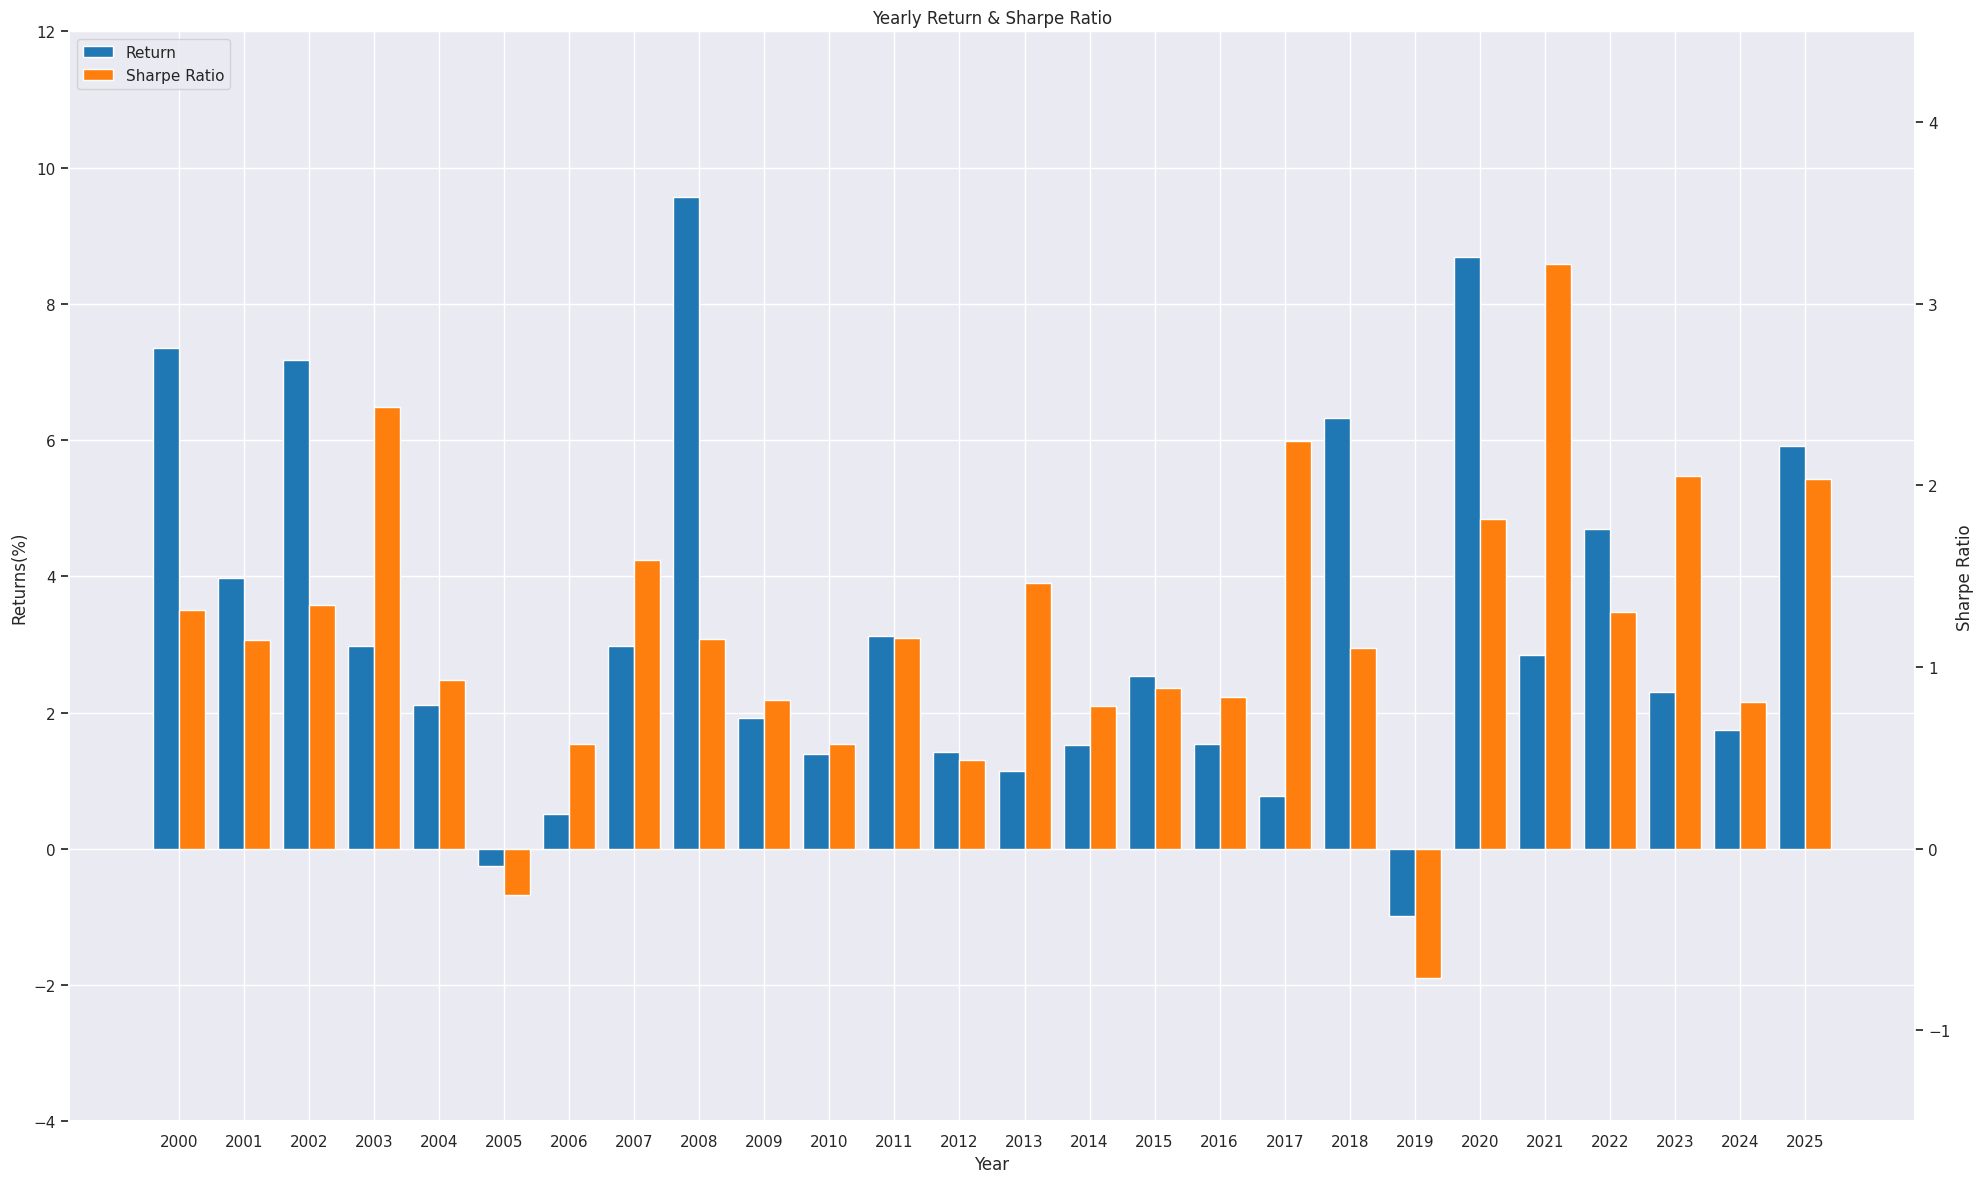

In [15]:
annual_ret = def_ret.resample('Y').sum()
annual_sr = def_ret.resample('Y').mean() * np.sqrt(252) / def_ret.resample('Y').std()
years = list(annual_ret.index.year)
x = np.arange(len(years))
width = 0.4
fig, ax1 = plt.subplots(figsize=(20, 12))
bars1 = ax1.bar(x - width/2, annual_ret * 100, width=width, label='Return', color='tab:blue')
ax1.set_ylabel('Returns(%)')
ax1.set_xticks(x)
ax1.set_xticklabels([str(y) for y in years])
ax1.set_xlabel('Year')
ax1.set_ylim(-4, 12)
ax1.grid(True)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, annual_sr, width=width, label='Sharpe Ratio', color='tab:orange')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(False)
ax2.set_ylim(-1.5, 4.5)
ax1.legend([bars1[0], bars2[0]], ['Return', 'Sharpe Ratio'], loc='upper left')
plt.title('Yearly Return & Sharpe Ratio')
plt.tight_layout()